In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Import data
SEED = 222   #设置随机种子
np.random.seed(SEED)
df = pd.read_csv('C:/Users/weimy/Desktop/2001_SPECTF Heart Data Set/SPECTF.train.txt',sep=',',header=None) #读取数据
df_test = pd.read_csv('C:/Users/weimy/Desktop/2001_SPECTF Heart Data Set/SPECTF.test.txt',sep=',',header=None) #读取数据 
df.columns.values
### Training and test set
from sklearn.model_selection import train_test_split #训练数据的包
from sklearn.metrics import roc_auc_score #roc、auc评判标准  

In [9]:
df.rename(columns={0:'y'},inplace=True)
df_test.rename(columns={0:'y'},inplace=True)

In [10]:
xtrain = df.iloc[:,1:]
xtrain
ytrain = df.iloc[:,0:1]
ytrain
xtest = df_test.iloc[:,1:]
xtest
ytest = df_test.iloc[:,0:1]
ytest


,y
0,1
1,1
2,1
3,1
4,1
...,...
182,0
183,0
184,0
185,0


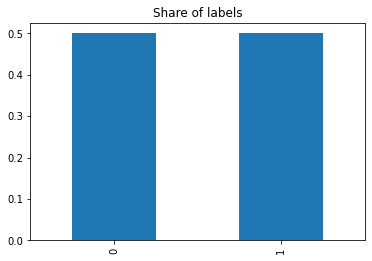

In [11]:
df.y.value_counts(normalize=True).plot(kind="bar", title="Share of labels")
plt.savefig('C:/Users/weimy/Desktop/2001_SPECTF Heart Data Set/labels.png')
plt.show()

In [12]:
#决策树的生成定义
import pydotplus  # you can install pydotplus with: pip install pydotplus
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

def print_graph(clf, feature_names):    #定义决策树的生成
    """Print decision tree."""
    graph = export_graphviz(
        clf,
        label="root",
        proportion=True,
        impurity=False,
        out_file=None,
        feature_names=feature_names,
        class_names={0: "N", 1: "P"},  #图像中0、1分别转化成N，P
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)
    return Image(graph.create_png())

In [13]:
ytest

,y
0,1
1,1
2,1
3,1
4,1
...,...
182,0
183,0
184,0
185,0


Decision tree ROC-AUC score: 0.675


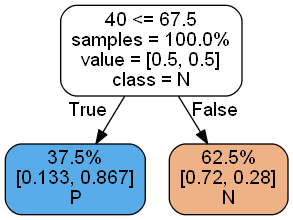

In [14]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=SEED) #最大深度为1的决策树
t1.fit(xtrain, ytrain) #训练数据
p = t1.predict_proba(xtest)[:,1] #预测指标

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p)) #输出AUC值
print_graph(t1, xtrain.columns) #打印决策树

Decision tree ROC-AUC score: 0.650


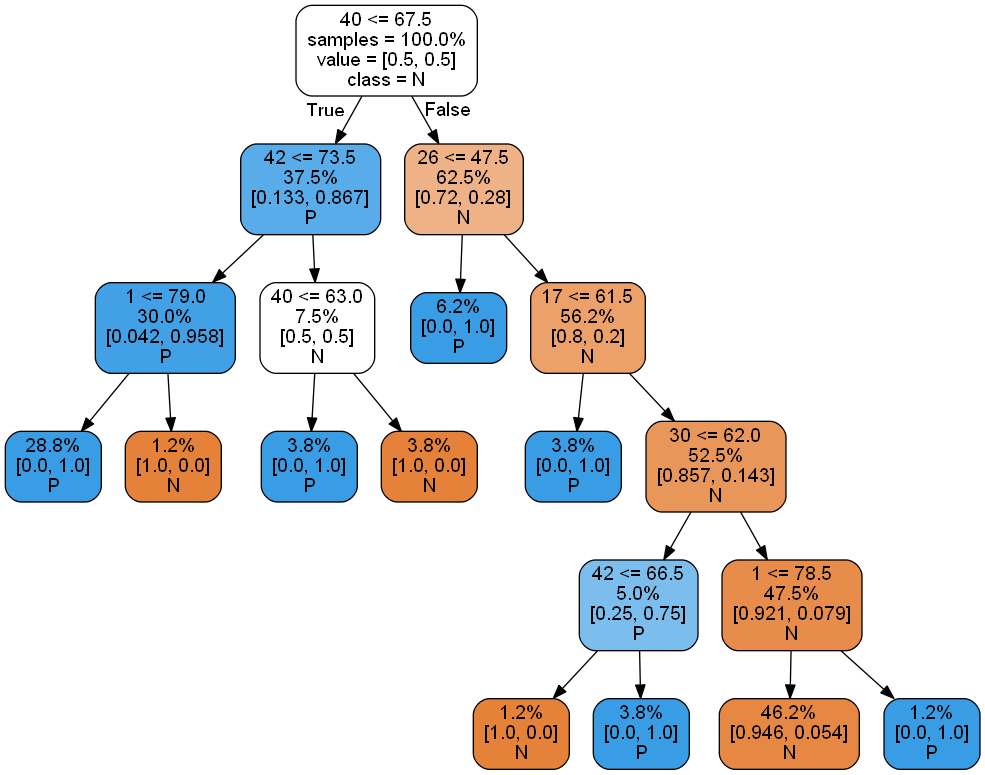

In [15]:
t2 = DecisionTreeClassifier(max_depth=5, random_state=SEED) #最大深度为5的决策树
t2.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t2, xtrain.columns)

Decision tree ROC-AUC score: 0.700


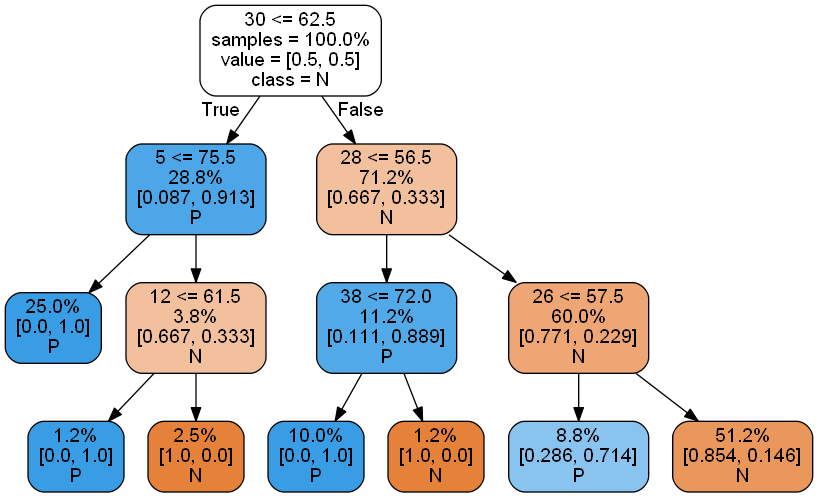

In [18]:
drop = [40] #删除影响最大的因素
xtrain_slim = xtrain.drop(drop, 1)
xtest_slim = xtest.drop(drop, 1)

t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t3, xtrain_slim.columns)

In [26]:
# A host of Scikit-learn models
# A host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline


def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=5)
    lr = LogisticRegression(C=1, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [27]:
models = get_models()
P = train_predict(models)
score_models(P, ytest)

Fitting models.
svm... done
knn... done
naive bayes... done
mlp-nn... 

C:\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


done
random forest... done
gbm... done
logistic... done
Done.

Scoring models.
svm                       : 0.771
knn                       : 0.758
naive bayes               : 0.804
mlp-nn                    : 0.688
random forest             : 0.778
gbm                       : 0.775
logistic                  : 0.631
Done.



C:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
<ipython-input-26-3fd9e363b2d3>:45: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(xtrain, ytrain)
C:\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: Conve

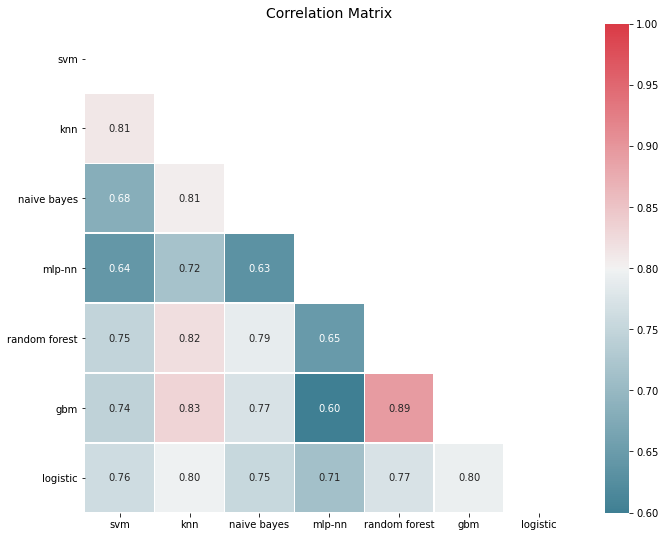

In [18]:
from mlens.visualization import corrmat

corrmat(P.corr(),inflate=False)
plt.show()

In [19]:
print('Ensemble ROC-AUC score: %.3f' % roc_auc_score(ytest,P.mean(axis=1))) #boosting模型

NameError: name 'ytest' is not defined

In [30]:
include = [c for c in P.columns if c not in ["mlp-nn"]]
print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.loc[:, include].mean(axis=1)))

Truncated ensemble ROC-AUC score: 0.802


In [31]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest,P_base_learners,P_ensemble,labels,ens_label):
    plt.figure(figsize=(10,8))
    plt.plot([0,1],[0,1],'k--')
    
    cm = [plt.cm.rainbow(i)
         for i in np.linspace(0,1.0,P_base_learners.shape[1]+1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:,i]
        fpr,tpr,_ = roc_curve(ytest,p)
        plt.plot(fpr,tpr,label=labels[i],c=cm[i+1])  #五种方法的roc曲线
        
    fpr,tpr,_ = roc_curve(ytest,P_ensemble)
    plt.plot(fpr,tpr,label=ens_label,c=cm[0])   #boosting集成的roc曲线
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)

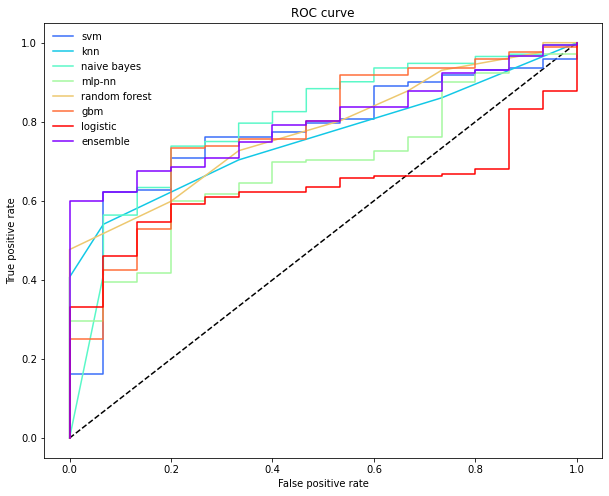

In [32]:
plot_roc_curve(ytest,P.values,P.mean(axis=1),list(P.columns),'ensemble')

In [193]:
include = [c for c in P.columns if c not in ['svm']]
print('Truncated ensemble ROC-AUC score: %.3f' %roc_auc_score(ytest,P.loc[:,include].mean(axis=1)))

Truncated ensemble ROC-AUC score: 0.863


# GLM based on lasso regression


In [33]:
#挑选出了变量V5,V25,V27,V29,V31,V33,V41
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Import data
SEED = 222   #设置随机种子
np.random.seed(SEED)
df = pd.read_csv('C:/Users/weimy/Desktop/2001_SPECTF Heart Data Set/SPECTF.train.txt',sep=',',header=None) #读取数据
df_test = pd.read_csv('C:/Users/weimy/Desktop/2001_SPECTF Heart Data Set/SPECTF.test.txt',sep=',',header=None) #读取数据 
df.columns.values
df.rename(columns={0:'y'},inplace=True)
df_test.rename(columns={0:'y'},inplace=True)
### Training and test set
from sklearn.model_selection import train_test_split #训练数据的包
from sklearn.metrics import roc_auc_score #roc、auc评判标准 
df

,y,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,1,59,52,70,67,73,66,72,61,58,...,66,56,62,56,72,62,74,74,64,67
1,1,72,62,69,67,78,82,74,65,69,...,65,71,63,60,69,73,67,71,56,58
2,1,71,62,70,64,67,64,79,65,70,...,73,70,66,65,64,55,61,41,51,46
3,1,69,71,70,78,61,63,67,65,59,...,61,61,66,65,72,73,68,68,59,63
4,1,70,66,61,66,61,58,69,69,72,...,67,69,70,66,70,64,60,55,49,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0,70,75,72,72,67,71,71,78,63,...,66,67,68,70,70,71,64,67,56,54
76,0,59,57,67,71,66,68,68,70,56,...,62,64,56,53,71,68,64,63,56,56
77,0,67,64,73,75,77,77,74,70,65,...,61,64,65,60,68,75,74,80,67,68
78,0,68,65,72,72,47,74,76,74,67,...,64,69,71,73,73,75,68,56,58,44


In [21]:
df_lasso_train = df[['y',6,26,28,30,32,34,42]]
df_lasso_test = df_test[['y',6,26,28,30,32,34,42]]

In [22]:
xtrain_lasso = df_lasso_train.iloc[:,1:]
print(xtrain_lasso)
ytrain_lasso = df_lasso_train.iloc[:,0:1]
#ytrain_lasso
xtest_lasso = df_lasso_test.iloc[:,1:]
#xtest_lasso
ytest_lasso = df_lasso_test.iloc[:,0:1]
#ytest_lasso


    6   26  28  30  32  34  42
0   66  64  54  54  74  67  74
1   82  69  70  69  70  65  71
2   64  37  68  59  68  60  41
3   63  60  54  73  76  64  68
4   58  37  40  46  73  66  55
..  ..  ..  ..  ..  ..  ..  ..
75  71  61  58  69  75  65  67
76  68  79  70  77  69  54  63
77  77  71  61  69  76  66  80
78  74  48  69  69  79  66  56
79  69  63  57  68  75  67  68

[80 rows x 7 columns]


Decision tree ROC-AUC score: 0.561


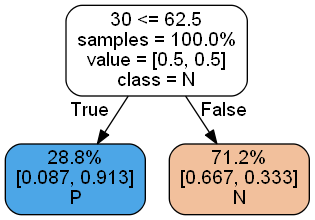

In [23]:
#决策树的生成定义
import pydotplus  # you can install pydotplus with: pip install pydotplus
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

def print_graph(clf, feature_names):    #定义决策树的生成
    """Print decision tree."""
    graph = export_graphviz(
        clf,
        label="root",
        proportion=True,
        impurity=False,
        out_file=None,
        feature_names=feature_names,
        class_names={0: "N", 1: "P"},  #图像中0、1分别转化成N，P
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)
    return Image(graph.create_png())

t1_lasso = DecisionTreeClassifier(max_depth=1, random_state=SEED) #最大深度为1的决策树
t1_lasso.fit(xtrain_lasso, ytrain_lasso) #训练数据
p_lasso = t1_lasso.predict_proba(xtest_lasso)[:,1] #预测指标

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest_lasso, p_lasso)) #输出AUC值
print_graph(t1_lasso, xtrain_lasso.columns) #打印决策树

Decision tree ROC-AUC score: 0.717


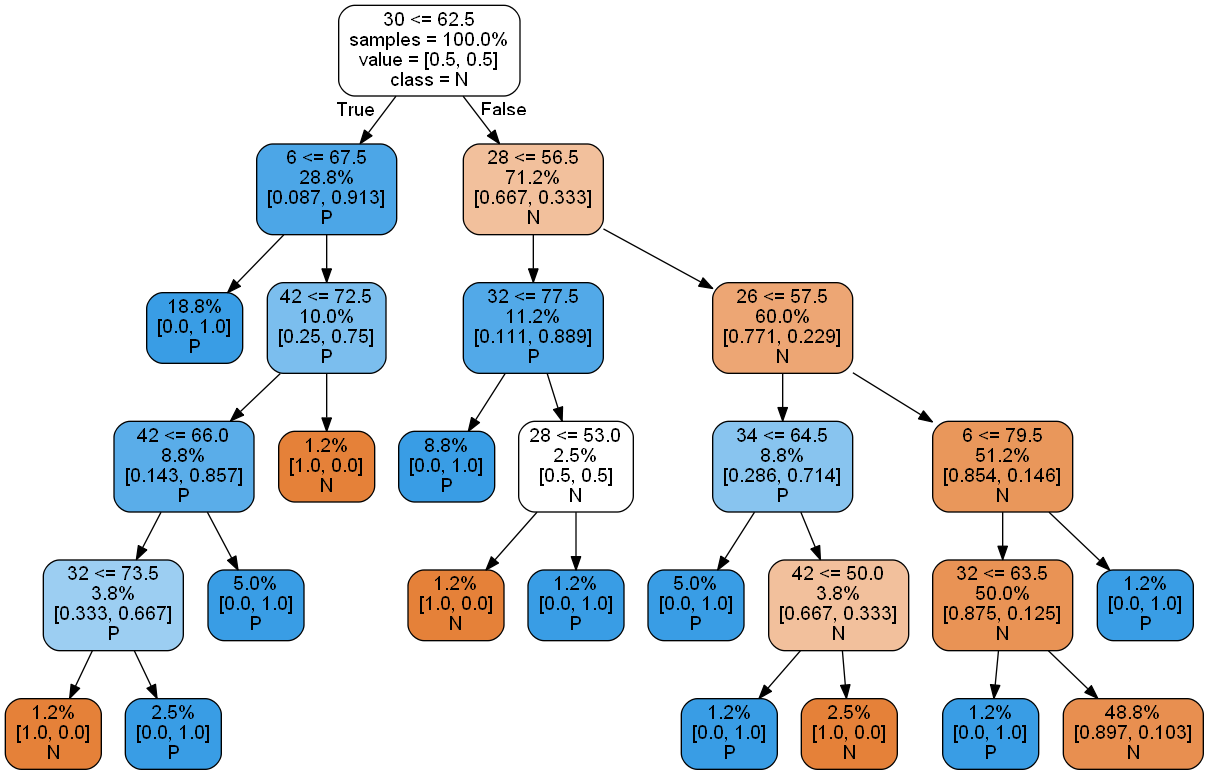

In [25]:
t2_lasso = DecisionTreeClassifier(max_depth=5, random_state=SEED) #最大深度为1的决策树
t2_lasso.fit(xtrain_lasso, ytrain_lasso) #训练数据
p2_lasso = t2_lasso.predict_proba(xtest_lasso)[:,1] #预测指标

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest_lasso, p2_lasso)) #输出AUC值
print_graph(t2_lasso, xtrain_lasso.columns) #打印决策树

Decision tree ROC-AUC score: 0.692


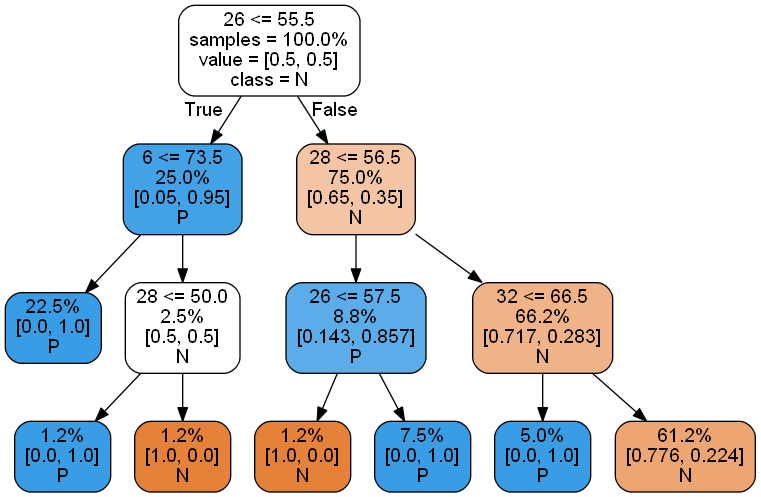

In [26]:
drop = [30] #删除影响最大的因素
xtrain_slim = xtrain_lasso.drop(drop, 1)
xtest_slim = xtest_lasso.drop(drop, 1)

t3_lasso = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t3_lasso.fit(xtrain_slim, ytrain_lasso)
p = t3_lasso.predict_proba(xtest_slim)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest_lasso, p))
print_graph(t3_lasso, xtrain_slim.columns)

In [27]:
# A host of Scikit-learn models
# A host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline


def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=5)
    lr = LogisticRegression(C=1, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest_lasso.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain_lasso, ytrain_lasso)
        P.iloc[:, i] = m.predict_proba(xtest_lasso)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [28]:
models = get_models()
P = train_predict(models)
score_models(P, ytest_lasso)

Fitting models.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... 

C:\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\anacond

done
logistic... done
Done.

Scoring models.
svm                       : 0.690
knn                       : 0.734
naive bayes               : 0.810
mlp-nn                    : 0.650
random forest             : 0.785
gbm                       : 0.786
logistic                  : 0.731
Done.



C:\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


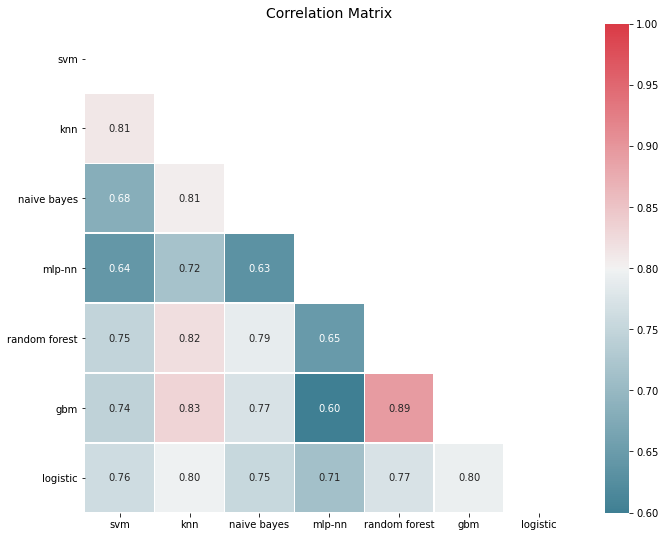

In [29]:
from mlens.visualization import corrmat

corrmat(P.corr(),inflate=False)
plt.show()

In [30]:
print('Ensemble ROC-AUC score: %.3f' % roc_auc_score(ytest_lasso,P.mean(axis=1))) #boosting模型

Ensemble ROC-AUC score: 0.776


In [36]:
include = [c for c in P.columns if c not in ["mlp-nn",'svm','logistic']]
print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest_lasso, P.loc[:, include].mean(axis=1)))

Truncated ensemble ROC-AUC score: 0.803


In [58]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest,P_base_learners,P_ensemble,labels,ens_label):
    plt.figure(figsize=(10,8))
    plt.plot([0,1],[0,1],'k--')
    
    cm = [plt.cm.rainbow(i)
         for i in np.linspace(0,1.0,P_base_learners.shape[1]+1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:,i]
        fpr,tpr,_ = roc_curve(ytest,p)
        plt.plot(fpr,tpr,label=labels[i],c=cm[i+1])  #五种方法的roc曲线
        
    fpr,tpr,_ = roc_curve(ytest,P_ensemble)
    plt.plot(fpr,tpr,label=ens_label,c=cm[0])   #boosting集成的roc曲线
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)

In [50]:
P.values[:,[0,1,2]]

array([[0.23007347, 0.2       , 0.00980964],
       [0.2618195 , 0.        , 0.94814337],
       [0.44758391, 0.4       , 0.58167455],
       [0.21595157, 0.        , 0.08634062],
       [0.45237055, 0.2       , 0.99992068],
       [0.47369491, 0.2       , 0.04556136],
       [0.37914488, 0.8       , 1.        ],
       [0.69863765, 0.8       , 0.99999999],
       [0.85400246, 1.        , 1.        ],
       [0.81038401, 0.8       , 0.9997726 ],
       [0.91709099, 0.8       , 0.9883415 ],
       [0.83125906, 1.        , 1.        ],
       [0.5       , 0.6       , 0.99983633],
       [0.84768299, 1.        , 1.        ],
       [0.8510365 , 1.        , 1.        ],
       [0.8142556 , 1.        , 1.        ],
       [0.18091471, 0.        , 0.01007659],
       [0.57365093, 0.8       , 0.97307491],
       [0.85271392, 1.        , 1.        ],
       [0.89297671, 0.8       , 0.99999999],
       [0.79675184, 0.6       , 0.99985177],
       [0.84899405, 1.        , 1.        ],
       [0.

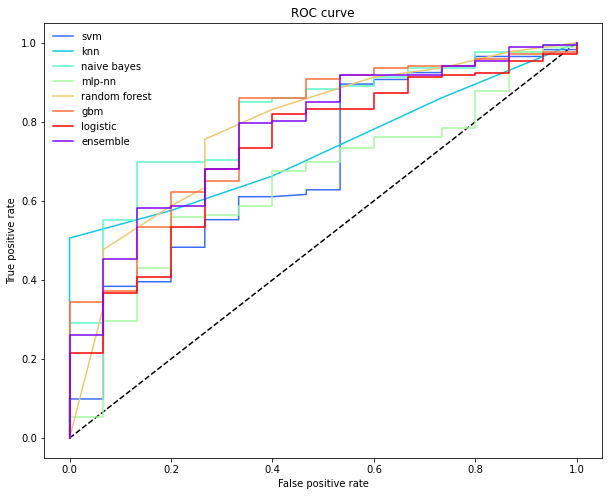

In [60]:
plot_roc_curve(ytest_lasso,P.values,P.mean(axis=1),list(P.columns),'ensemble')